In [1]:
#!nvidia-smi

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchsummary import summary

from DatasetLogReturn import StockDatasetLogReturn
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split

import math
import numpy as np
import pandas as pd
import random as rd
import matplotlib.pyplot as plt

In [3]:
configs = {
    "batch_size" : 32,
    "max_file_count" : 2179,
    "train_file" : 7,
    "validation_file" : 3,
    "test_file" : 3,
    "input_size" : 8,
    "output_size" : 1,
    "init_learning_rate" : 1e-4,
    "scheduler_factor": 0.5,
    "scheduler_patience": 2,
    "scheduler_min_lr": 3e-6,
    "epoch" : 10,
    "model_name" : "LSTM8",
}

configs["file_count"] = configs["train_file"] + configs["validation_file"] + configs["test_file"]
configs["model_folder"] = f"./models/{configs["model_name"]}/"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
tickers = list(map(str.strip,open("tickers_sp500.txt","r").readlines()))
filenames = ["./data/" + x + ".csv" for x in tickers]
rd.shuffle(filenames)
filenames = filenames[:configs["file_count"]]

train_files, test_files = train_test_split(filenames,test_size=configs["test_file"]/configs["file_count"])
train_files, val_files = train_test_split(train_files,test_size=configs["validation_file"]/(configs["train_file"] + configs["validation_file"]))

train_dataset = StockDatasetLogReturn(train_files, configs["input_size"], configs["output_size"])
train_dataset.Preprocess()
train_loader = DataLoader(train_dataset,batch_size=configs["batch_size"],shuffle=True)

val_dataset = StockDatasetLogReturn(val_files,configs["input_size"],configs["output_size"])
val_dataset.Preprocess()
val_loader = DataLoader(val_dataset,batch_size=configs["batch_size"],shuffle=True)

test_dataset = StockDatasetLogReturn(test_files,configs["input_size"],configs["output_size"])
test_dataset.Preprocess()
test_loader = DataLoader(test_dataset,batch_size=configs["batch_size"],shuffle=True)

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50827 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/33386 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/24116 [00:00<?, ?it/s]

In [41]:
torch.set_default_dtype(torch.float32)

class LSTMBlock(nn.Module) :
    def __init__(self, input_size, output_size) :
        super().__init__()
        self.LSTM = nn.LSTM(input_size,output_size,2,batch_first=True,bias=False)
        self.Dropout = nn.Dropout(p=0.2)
        self.LayerNorm = nn.LayerNorm(output_size)
    
    def forward(self, input) :
        h1,_ = self.LSTM(input)
        h2 = self.Dropout(h1)
        output = self.LayerNorm(h2)
        return output

class StockLSTM(nn.Module) :
    def __init__(self) :
        super().__init__()
        self.hidden_size = 512
        self.batch_size = configs["batch_size"]
        self.layer1 = LSTMBlock(6,self.hidden_size)
        self.layer2 = nn.Linear(self.hidden_size,1,bias=False)

    def forward(self, input) :
        input = torch.multiply(input,25)
        h1 = self.layer1(input)
        output = self.layer2(h1[:,-1,:])
        output = torch.multiply(output,0.04)
        return output


In [42]:
model = StockLSTM()
model = model.to(device)

summary(model,input_size=(configs["batch_size"],configs["input_size"],6))

Layer (type:depth-idx)                   Param #
├─LSTMBlock: 1-1                         --
|    └─LSTM: 2-1                         3,158,016
|    └─Dropout: 2-2                      --
|    └─LayerNorm: 2-3                    1,024
├─Linear: 1-2                            512
Total params: 3,159,552
Trainable params: 3,159,552
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─LSTMBlock: 1-1                         --
|    └─LSTM: 2-1                         3,158,016
|    └─Dropout: 2-2                      --
|    └─LayerNorm: 2-3                    1,024
├─Linear: 1-2                            512
Total params: 3,159,552
Trainable params: 3,159,552
Non-trainable params: 0

In [43]:
try_input = torch.zeros(configs["batch_size"],configs["input_size"],6)
try_input = try_input.to(device=device)

dataset = model(try_input)

In [8]:
L1loss_function = torch.nn.L1Loss()

def loss_fn(target, input) :
    penalty = 0.005
    return torch.mul(torch.mean(torch.lt(torch.mul(target,input),0).type(torch.float32)),penalty) + L1loss_function(target,input)

# loss_fn = torch.nn.L1Loss()

In [9]:
optimizer = torch.optim.Adam(model.parameters(), lr = configs["init_learning_rate"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    'min',
    factor=configs['scheduler_factor'],
    patience=configs['scheduler_patience'],
    min_lr=configs['scheduler_min_lr']
)


In [44]:
train_losses = []
val_losses = []
avarage_train_losses = []
avarage_val_losses = []
learning_rates = []

model_folder = configs["model_folder"]
best_loss = 1000000

# temp const
scaler = torch.tensor((np.array([0.04,1,1,1,1,0.02]).reshape(-1,1) @ np.array([1] * configs["input_size"]).reshape(1,-1)).T)
scaler = scaler.type(torch.float32)

for epoch in tqdm(range(configs["epoch"])) :

    model.train()

    learning_rates.append(optimizer.param_groups[0]['lr'])

    cur_train_loss = []
    for input,target in tqdm(train_loader) :

        close_price_input = torch.mul(torch.transpose(input[:,:,:],1,2),scaler)
        close_price_target = target[:,4,:]
        close_price_input = close_price_input.to(device)
        close_price_target = close_price_target.to(device)

        if(close_price_input.shape[0] != configs["batch_size"]) :
            continue

        optimizer.zero_grad()

        output = model(close_price_input)

        loss = loss_fn(output,close_price_target)

        loss.backward()

        optimizer.step()

        train_losses.append(loss.to(torch.device("cpu")).item())
        cur_train_loss.append(loss.to(torch.device("cpu")).item())

    avarage_train_loss = np.mean(np.array(cur_train_loss))
    avarage_train_losses.append(avarage_train_loss)

    model.eval()

    with torch.no_grad() :
        cur_val_loss = []
        for input,target in tqdm(val_loader) :

            close_price_input = torch.mul(torch.transpose(input[:,:,:],1,2),scaler)
            close_price_target = target[:,4,:]
            close_price_input = close_price_input.to(device)
            close_price_target = close_price_target.to(device)

            if(close_price_input.shape[0] != configs["batch_size"]) :
                continue

            output = model(close_price_input)

            loss = loss_fn(output,close_price_target)

            val_losses.append(loss.to(torch.device("cpu")).item())
            cur_val_loss.append(loss.to(torch.device("cpu")).item())

        avarage_val_loss = np.mean(np.array(cur_val_loss))
        avarage_val_losses.append(avarage_val_loss)

        scheduler.step(avarage_val_loss)
        
        if(best_loss > avarage_val_loss) :

            state = {
                'epoch': epoch,
                'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict(),
                'train_loss': avarage_train_loss,
                'val_loss': avarage_val_loss,
                'best_val_loss': best_loss,
            }

            best_loss = avarage_val_loss

            torch.save(state, model_folder + "LSTM.pth.tar")

    print("train loss : ",avarage_train_loss)
    print("val loss : ",avarage_val_loss)


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1589 [00:00<?, ?it/s]

  0%|          | 0/1044 [00:00<?, ?it/s]

train loss :  0.024443792175708023
val loss :  0.01962135397237105


  0%|          | 0/1589 [00:00<?, ?it/s]

  0%|          | 0/1044 [00:00<?, ?it/s]

train loss :  0.024381266098694704
val loss :  0.019622447138807574


  0%|          | 0/1589 [00:00<?, ?it/s]

  0%|          | 0/1044 [00:00<?, ?it/s]

train loss :  0.02443615516403723
val loss :  0.01962158847635939


  0%|          | 0/1589 [00:00<?, ?it/s]

  0%|          | 0/1044 [00:00<?, ?it/s]

train loss :  0.024423206908867626
val loss :  0.01962112060329258


  0%|          | 0/1589 [00:00<?, ?it/s]

  0%|          | 0/1044 [00:00<?, ?it/s]

train loss :  0.024408070045647677
val loss :  0.019620613105709405


  0%|          | 0/1589 [00:00<?, ?it/s]

  0%|          | 0/1044 [00:00<?, ?it/s]

train loss :  0.02440486194258579
val loss :  0.019621928757340545


  0%|          | 0/1589 [00:00<?, ?it/s]

  0%|          | 0/1044 [00:00<?, ?it/s]

train loss :  0.024457675359101604
val loss :  0.019620679175143672


  0%|          | 0/1589 [00:00<?, ?it/s]

  0%|          | 0/1044 [00:00<?, ?it/s]

train loss :  0.02442962292028164
val loss :  0.019620997484769826


  0%|          | 0/1589 [00:00<?, ?it/s]

  0%|          | 0/1044 [00:00<?, ?it/s]

train loss :  0.024487796577951058
val loss :  0.019622320021758944


  0%|          | 0/1589 [00:00<?, ?it/s]

  0%|          | 0/1044 [00:00<?, ?it/s]

train loss :  0.024421618410365033
val loss :  0.019621595377790048


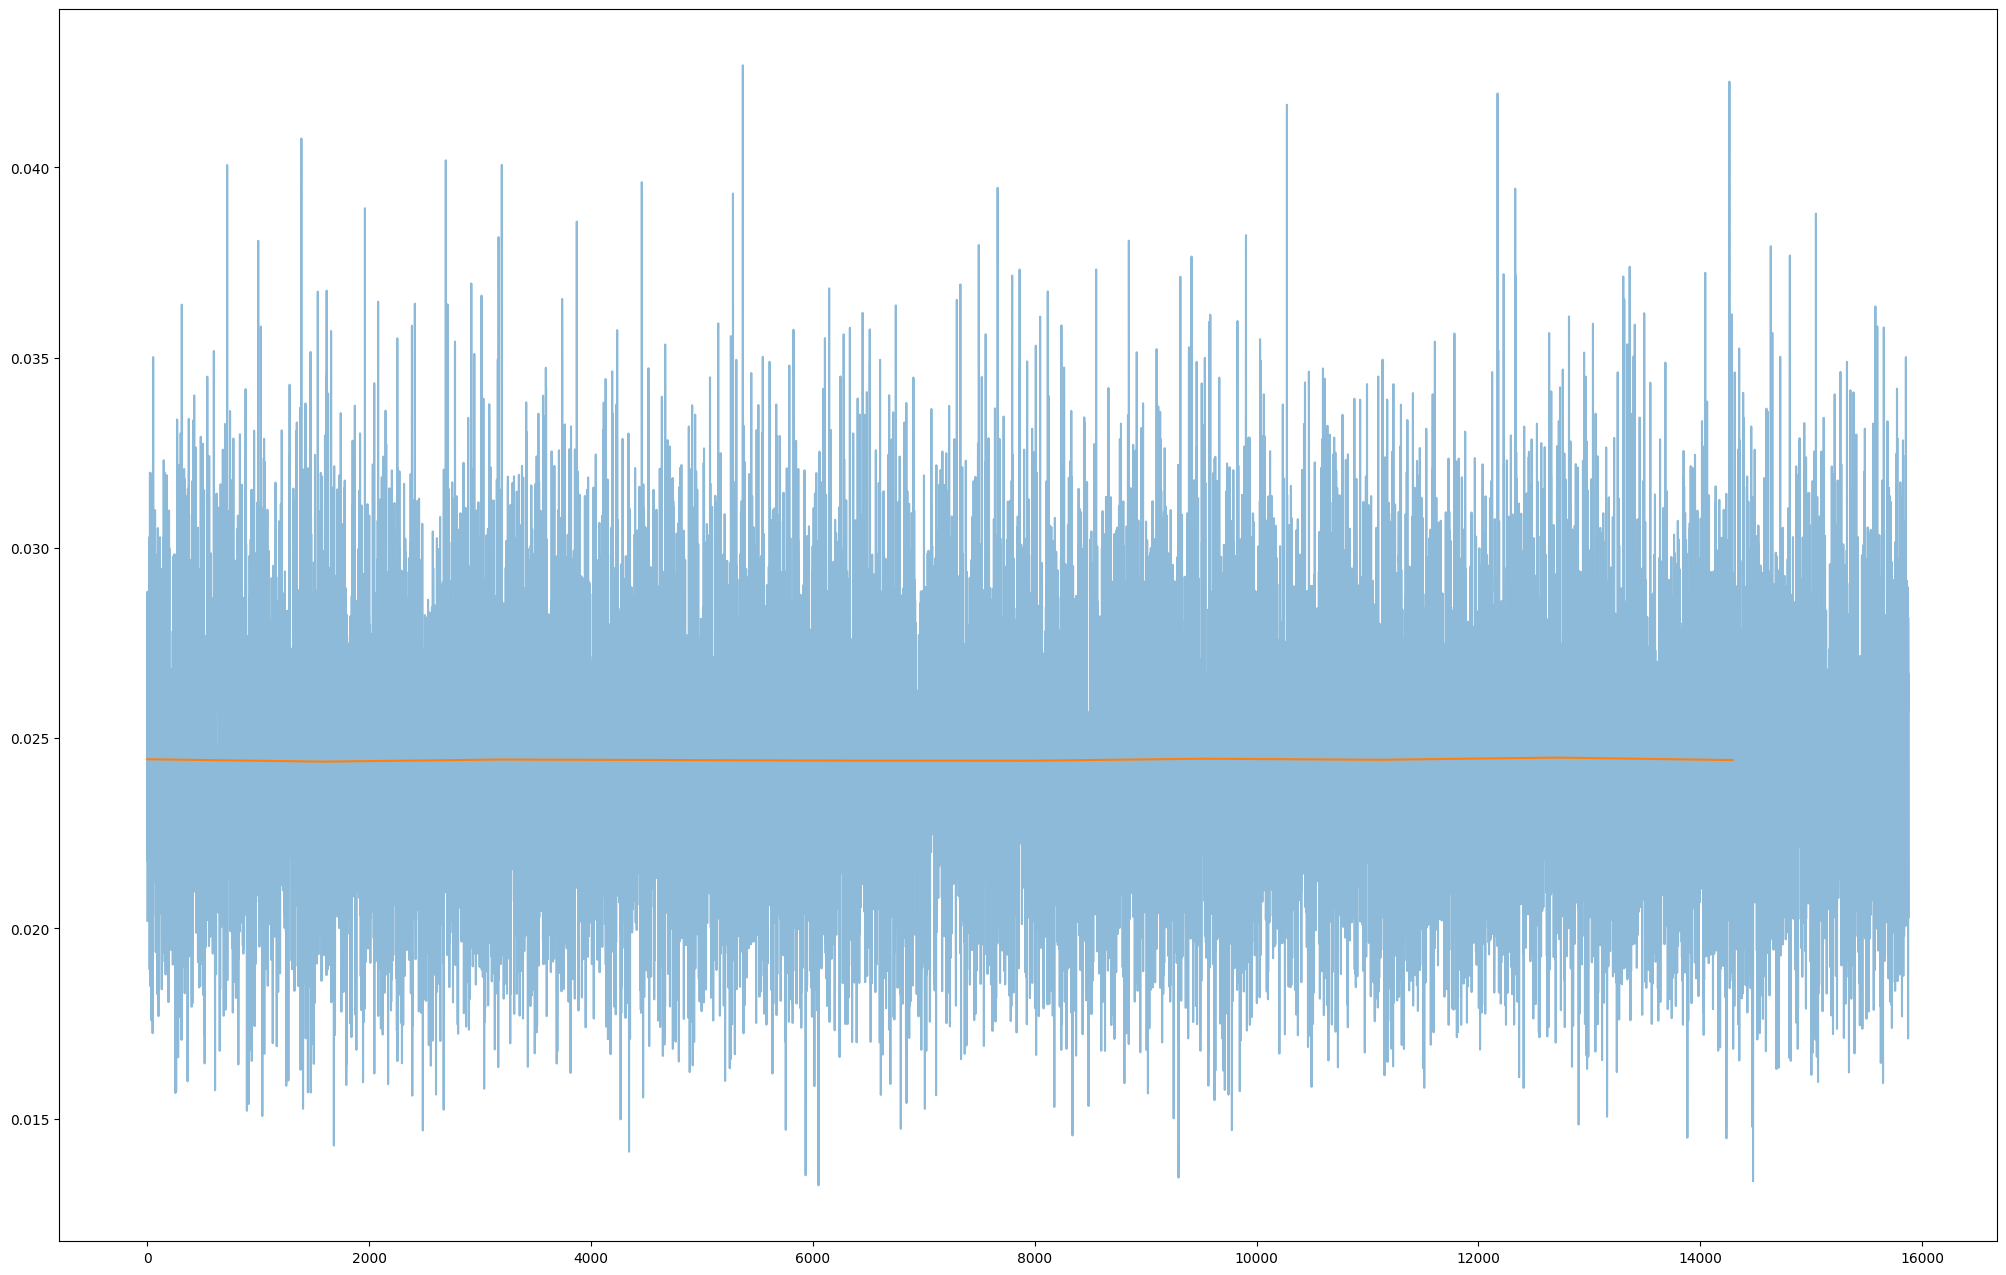

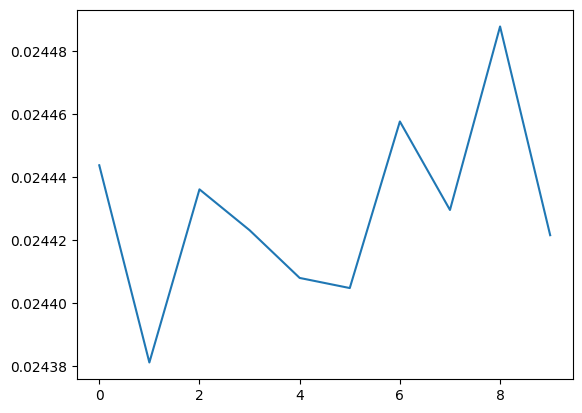

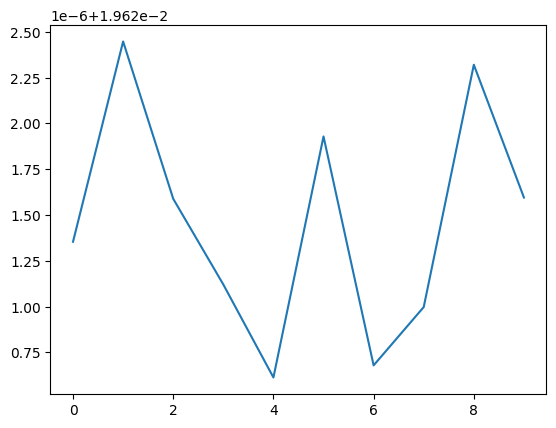

In [45]:
plt.figure(figsize=(25, 16))
plt.plot(train_losses,alpha=0.5)
plt.plot(list(range(0,len(train_losses),int(len(train_losses) / len(avarage_train_losses)))),avarage_train_losses)
plt.show()
plt.plot(avarage_train_losses)
plt.show()
plt.plot(avarage_val_losses)
plt.show()

In [46]:
train_losses_file = open(configs["model_folder"] + "train_losses.txt",'w')
val_losses_file = open(configs["model_folder"] + "val_losses.txt","w")

for value in train_losses :
    train_losses_file.write(f"{value}\n")

for value in val_losses :
    val_losses_file.write(f"{value}\n")

train_losses_file.close()
val_losses_file.close()

In [62]:
best_model = StockLSTM()
# best_model.load_state_dict(torch.load(configs["model_folder"] + "LSTM.pth.tar")['model'])

best_model.to(device)
best_model.eval()

StockLSTM(
  (layer1): LSTMBlock(
    (LSTM): LSTM(6, 512, num_layers=2, bias=False, batch_first=True)
    (Dropout): Dropout(p=0.2, inplace=False)
    (LayerNorm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (layer2): Linear(in_features=512, out_features=1, bias=False)
)

In [60]:
with torch.no_grad() :
    cur_test_loss = []
    for input,target in tqdm(test_loader) :

        close_price_input = torch.mul(torch.transpose(input[:,:,:],1,2),scaler)
        close_price_target = target[:,4,:]
        close_price_input = close_price_input.to(device)
        close_price_target = close_price_target.to(device)

        if(close_price_input.shape[0] != configs["batch_size"]) :
            continue

        output = best_model(close_price_input)

        loss = loss_fn(output,close_price_target)

        cur_test_loss.append(loss.to(torch.device("cpu")).item())

    avarage_test_loss = np.mean(np.array(cur_test_loss))

print(avarage_test_loss)

  0%|          | 0/754 [00:00<?, ?it/s]

0.02464403570994517


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

0.027280904 -> 0.033077385 
0.00846264 -> 0.03440498 
0.027702712 -> 0.036157094 
-0.010989148 -> 0.03510885 **
-0.0013822329 -> 0.03725605 **
0.01373648 -> 0.03420838 
-0.02346552 -> 0.032419637 **
0.016620858 -> 0.031818107 
-0.056512143 -> 0.030969512 **
-0.030998778 -> 0.025248148 **
0.12525128 -> 0.007173501 
-0.028170828 -> 0.013068436 **
0.020202698 -> 0.029396249 
-0.0053476966 -> 0.033837385 **
0.01990779 -> 0.036206305 
0.044965845 -> 0.03537968 
0.059737533 -> 0.033957377 
0.15228924 -> 0.032347143 
0.15762901 -> 0.02640221 
0.09594127 -> 0.021641832 
-0.02475179 -> 0.025124967 **
-0.071189456 -> 0.029427134 **
-0.07946418 -> 0.035669874 **
-0.06403746 -> 0.023973128 **
-0.038820002 -> 0.0068456703 **
0.080042735 -> -0.00478981 **
0.058813017 -> -0.0043399152 **
-0.013692594 -> 0.021861104 **
-0.020427812 -> 0.03255348 **
0.014897877 -> 0.035471644 
0.011029468 -> 0.034260273 
0.044690236 -> 0.030749511 
-0.021202233 -> 0.031300873 **
-0.027151005 -> 0.035395663 **
0.0091325

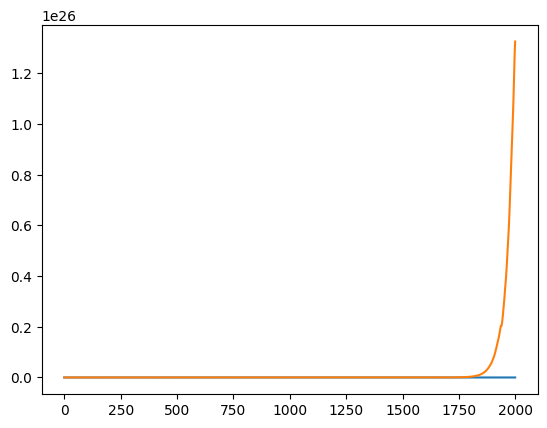

In [63]:
plot_dataset = StockDatasetLogReturn(["./data/A.csv"],configs["input_size"],1)

real = [1000]
predict = [1000]
price = 1000

feed_queue = list(range(plot_dataset.__len__()))
rd.shuffle(feed_queue)
predict_output = []
real_output = []
with torch.no_grad() : 
    for i in tqdm(range(0,plot_dataset.__len__(),configs["batch_size"])) :
        close_price_input = []
        close_price_target = []
        for j in range(configs["batch_size"]) :
            input,target = plot_dataset.__getitem__(i + j)
            close_price_input.append(torch.mul(torch.transpose(input[None,:,:],1,2),scaler))
            close_price_target.append(target[4].numpy())
        close_price_input = torch.cat(close_price_input).to(device)

        output = best_model(close_price_input)
        output = output.to(torch.device("cpu")).numpy()

        for j in range(configs["batch_size"]) :
            real_output.append(math.exp(close_price_target[j][0]))
            predict_output.append(math.exp(output[j][0]))
            print(close_price_target[j][0],"->",output[j][0],"**" if close_price_target[j][0] * output[j][0] < 0 else "")

for i in range(len(predict_output)) :
    predict.append(predict[-1] * predict_output[i])
    real.append(real[-1] * real_output[i])

plt.plot(real[0:2000])
plt.plot(predict[0:2000])
plt.show()

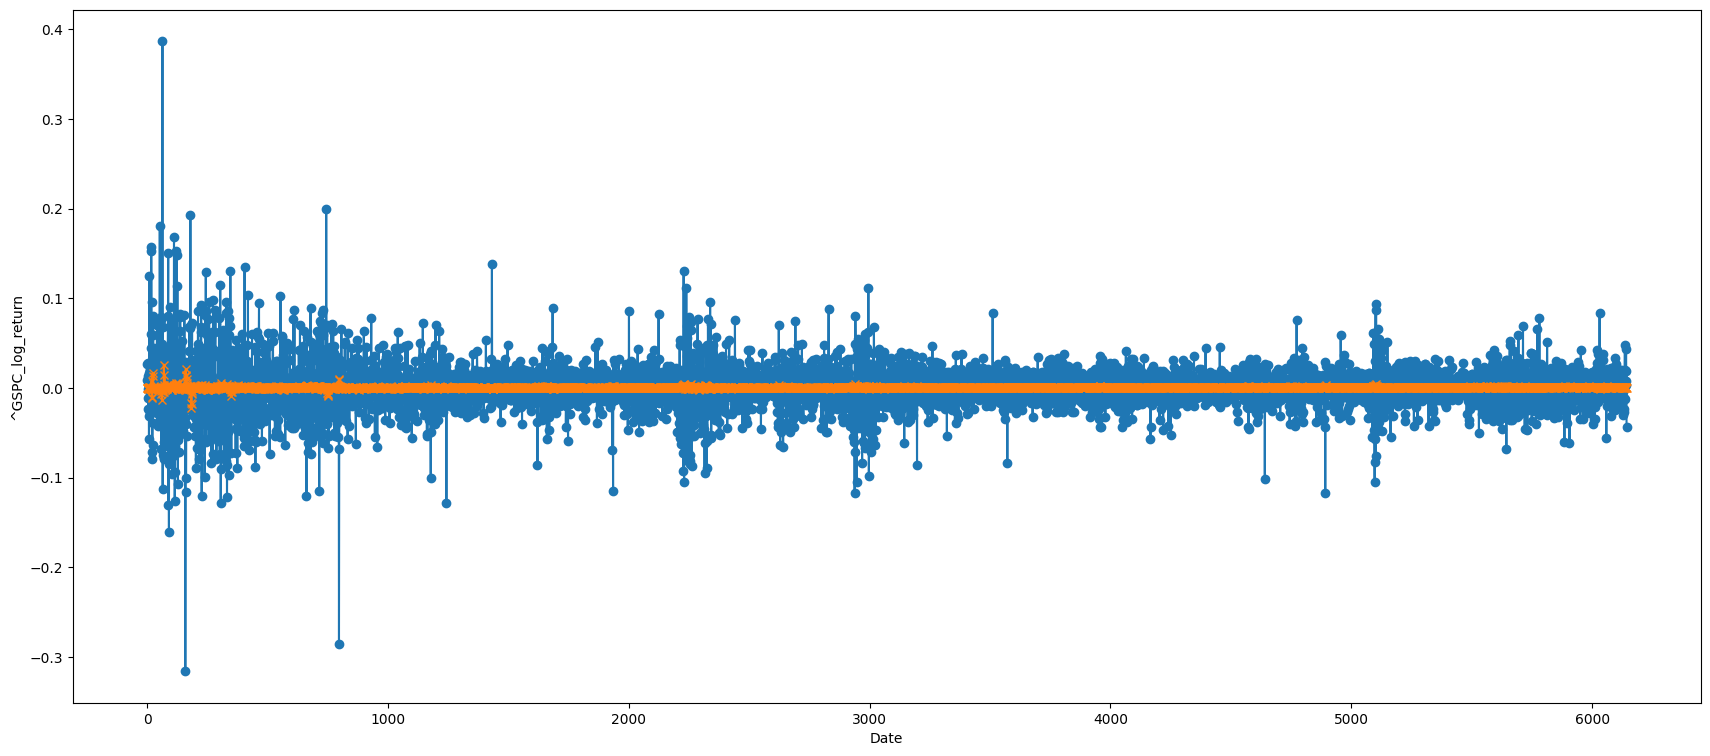

In [28]:
log_real_output = list(map(math.log,real_output))
log_predict_output = list(map(math.log,predict_output))
plt.figure(figsize=(21, 9))
plt.plot(log_real_output, label="Actual", marker='o')
plt.plot(log_predict_output, label= "Predicted",marker='x')
plt.xlabel('Date')
plt.ylabel('^GSPC_log_return')
plt.show()

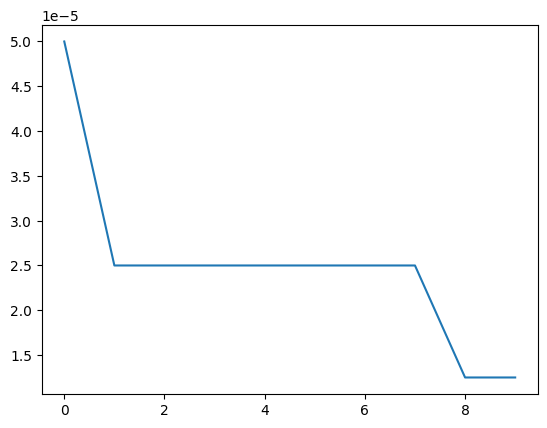

In [29]:
plt.plot(learning_rates)
plt.show()